# Colab Setup

In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [39]:
"""
Change directory to where this file is located
"""
%cd '/content/drive/MyDrive/MLDL_lab/'

/content/drive/MyDrive/MLDL_lab


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 35.1 MB/s 
     |████████████████████████████████| 7.6 MB 54.8 MB/s 
     |████████████████████████████████| 182 kB 71.5 MB/s 


In [40]:
import math
import pickle
from pathlib import Path
import sys
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchtext

import pandas as pd
import numpy as np

from data.data import prepareData

In [ ]:
"""
import modules you need
"""

In [41]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))
print("Using torchtext version: {}".format(torchtext.__version__))

Using PyTorch version: 1.13.0+cu116, Device: cuda
Using torchtext version: 0.14.0


In [42]:
SEED = 1111

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Practice 1. Seq2seq model with Attention Mechanism

## Question 1.  Dataset

[About the Dataset]
* Translation Task
  - French(src) -> English(trg)
  - Sequence to Sequence
* Language tokens
  - src: 4,345 words in our dictionary
  - trg: 2,803 words in our dictionary
* Set max length to 10
* 10,599 pairs

In [43]:
MAX_LENGTH = 10
BATCH_SIZE = 64

TRAIN_RATIO = 0.7  # train dataset ratio, should be a float in (0, 0.8]
VALID_RATIO = 0.8 - TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [44]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length=max_length

        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)
    
    def collate_fn(self, data):
        x_batch = []; y_batch = []
        
        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))
        
        return torch.stack(x_batch), torch.stack(y_batch)

In [45]:
dataset = TranslateDataset(max_length=MAX_LENGTH)
        
print("\n")
print("This is data example")
print(random.choice(dataset.pairs))

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)
print("\n")
print(f"This is dataset_size: {len(dataset)}")
print(f"train_size: {train_size}")
print(f"valid_data: {valid_size}")
print(f"test_data: {len(test_data)}")

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


This is data example
['vous etes une de ces menteuses !', 'you are such a liar !']


This is dataset_size: 10599
train_size: 7419
valid_data: 1059
test_data: 2121


In [9]:
"""
(1) Print the 1st elements of the 1st batch in the train_dataloader.

(2) Then, convert the elements into word format.
You can use dataset.input_lang.index2word and dataset.output_lang.index2word to convert the indices into words.
Any printed format is allowed if you can check the results.
"""
########## Your Code #########
x, y = next(iter(train_dataloader)) # 따로 만들어줌
sample_x = x[0]
sample_y = y[0]
sample_x_sentence = f"{' '.join([dataset.input_lang.index2word[i] for i in sample_x.tolist()])}"
sample_y_sentence = f"{' '.join([dataset.output_lang.index2word[i] for i in sample_y.tolist()])}"

print("sample_x: ", sample_x) ## (1)
print(sample_x_sentence) ## (2)
print("\nsample_y: ", sample_y) ## (1)
print(sample_y_sentence) ## (2)
##############################

sample_x:  tensor([   0,   89,   24, 1595,  202, 1108,    5,    1, 4345, 4345])
SOS maintenant il regarde la tele . EOS PAD PAD

sample_y:  tensor([   0,   14,   40,  662,  595,  238,    4,    1, 2803, 2803])
SOS he is watching tv now . EOS PAD PAD


'\n<강의영상 코드>\nsample_x, sample_y = next(iter(Train_dataloader))\nsample_x = sample_x.squeeze(0)\nsample_y = sample_y.squeeze(0)\n\nprint("sample_x: ", sample_x)\nprint(\' \'.join([dataset.input_lang.index2word[i] for i in sample_x.tolist()]))\nprint("sample_y: ", sample_y)\nprint(\' \'.join([dataset.output_lang.index2word[i] for i in sample_y.tolist()]))\n'


```
[answer example for Q(1) & Q(2)] 
sample_x:  tensor([   0,  210,  211,  121, 2640,    5,    1, 4345, 4345, 4345])
SOS tu es tres efficace . EOS PAD PAD PAD

sample_y:  tensor([   0,  129,   78,  303, 1548,    4,    1, 2803, 2803, 2803])
SOS you re very efficient . EOS PAD PAD PAD
```



In [11]:
"""
(3) Print the words whose indices are 0 and 1 in each dataset of input_lang and output_lang.
Check whether the indices 0 and 1 represent the same words in the input_lang and the output_lang.
You can use dataset.input_lang.index2word and dataset.output_lang.index2word to convert the indices into words.
"""
########## Your Code #########
input_lang_zero_word = dataset.input_lang.index2word[0]
output_lang_zero_word = dataset.output_lang.index2word[0]
input_lang_one_word = dataset.input_lang.index2word[1]
output_lang_one_word = dataset.output_lang.index2word[1]

print("The index 0 in each language represents....")
print(f"fra: {input_lang_zero_word}")
print(f"eng: {output_lang_zero_word}")
print("\nThe index 1 in each language represents....")
print(f"fra: {input_lang_one_word}")
print(f"eng: {output_lang_one_word}")
##############################


The index 0 in each language represents....
fra: SOS
eng: SOS

The index 1 in each language represents....
fra: EOS
eng: EOS


In [12]:
"""
(4) Print the index of [Pad] in each dataset of input_lang and output_lang.
Check whether the input_lang and the output_lang have same index for [PAD].
"""
########## Your Code #########
input_lang_pad_idx = dataset.input_lang.word2index['PAD']
output_lang_pad_idx = dataset.output_lang.word2index['PAD']

print("Check the indices of PAD token for each language")
print(f"fra: {input_lang_pad_idx}")
print(f"eng: {output_lang_pad_idx}")
##############################

Check the indices of PAD token for each language
fra: 4345
eng: 2803


## Question 2. Encoder

We are going to implement the Encoder part using single layer of LSTM.

In [13]:
# Initialize Model
in_dim = dataset.input_lang.n_words # number of words in french (=4346)
out_dim = dataset.output_lang.n_words # number of word in english (=2804)
emb_dim = 512 # embbeding size
hid_dim = 256 # vector size of encoder output

print(f'\nin_dim: {in_dim}\tout_dim: {out_dim}\temb_dim: {emb_dim}\thid_dim: {hid_dim}\n')


in_dim: 4346	out_dim: 2804	emb_dim: 512	hid_dim: 256



In [14]:
"""
(1) Try embedding the sample_x using the in_dim and emb_dim (use nn.Embedding)
Print the shapes of the embeded_x. embeded_x will be used again in Q(3).
"""
x, y = next(iter(train_dataloader))
sample_x = x[0]
print(f"sample_x: {sample_x.shape}")

########## Your Code #########
embedded_x = nn.Embedding(in_dim, emb_dim)(sample_x)
print(f"embedded_x: {embedded_x.shape}")
##############################

sample_x: torch.Size([10])
embedded_x: torch.Size([10, 512])


In [15]:
"""
(2) Initialize hidden and cell states for unbatched input.
You can initialize the states using torch.zeros.
Use hid_dim for their intialized sizes; Hout, Hcell.
Initialized hidden and cell states will be used again in Q(3).
Ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

- cell_0 : (1, hid_dim)
- hidden_0 : (1, hid_dim)
"""

########## Your Code #########
hidden_0 = torch.zeros(1, hid_dim)
cell_0 = torch.zeros(1, hid_dim)
print('Initialize hidden and cell states')
print(f'hidden_0: {hidden_0.shape}\tcell_0: {cell_0.shape}')
##############################

Initialize hidden and cell states
hidden_0: torch.Size([1, 256])	cell_0: torch.Size([1, 256])


In [16]:
"""
(3) Get outputs of Encoder using torch.nn.LSTM.
Use embedded_x, hidden_0, cell_0 as inputs. 
enc_hiddens will be used again in Decoder-Q(3) and Attention-Q(2)
Ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

INPUT
- embedded_x : (MAX_LENGTH, emb_dim)
- hidden_0 : (1, hid_dim)
- cell_0 : (1, hid_dim)

OUTPUT
- hiddens : (MAX_LENGTH, hid_dim)
- hidden : (1, hid_dim)
- cell : (1, hid_dim)
"""

emb_dim = 512 # embbeding size
hid_dim = 256 # vector size of encoder output

########## Your Code #########
lstm = torch.nn.LSTM(input_size=emb_dim, hidden_size=hid_dim)

hiddens, (hidden, cell) = lstm(embedded_x, (hidden_0, cell_0))

print('LSTM Encoder outputs')
print(f'hiddens: {hiddens.shape}\thidden: {hidden.shape}\tcell: {cell.shape}')
##############################

######### DO NOT MODIFY ########
print('\n')
check = ("Yes" if torch.sum(hiddens[-1]-hidden) == 0 else "No")
print(f"Is hidden equal to the last value of hiddens? : {check}")
print(f"Assigning encoder outputs for decoder (w/attention, see next question)...")
enc_hiddens = hiddens
################################

LSTM Encoder outputs
hiddens: torch.Size([10, 256])	hidden: torch.Size([1, 256])	cell: torch.Size([1, 256])


Is hidden equal to the last value of hiddens? : Yes
Assigning encoder outputs for decoder (w/attention, see next question)...


## Question 3. Decoder

We are going to implement the Decoder part using single layer of LSTM.

In [18]:
"""
(1) Try embedding the sample_y using the given out_dim and emb_dim (Use nn.Embedding)
Print the shapes of the embedded_y.
embedded_y will be used again in Q(3).
"""

########## Your Code #########
embedded_y = nn.Embedding(out_dim, emb_dim)(sample_y)
print(f"sample_y: {sample_y.shape}")
print(f"embedded_y: {embedded_y.shape}")
##############################

sample_y: torch.Size([10])
embedded_y: torch.Size([10, 512])


In [37]:
"""
(2) Initialize the inputs (hidden_0, cell_0, input_0) for the Decoder
They will be used again in Q(3).
Please refer to the class material of Lecture 9 for more details.
Ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

- cell_0 : Initialize cell state for unbatched input. 
           Use hid_dim for its intialized size; Hcell. (1, hid_dim)
           You can initialize the cell state using torch.zeros.
- input_0 : (embed_dim)
- hidden_0 : (1, hid_dim)
             You have to use the output of the Encoder for hidden_0.
"""

########## Your Code #########
cell_0 = torch.zeros(1, hid_dim)
input_0 = embedded_y[0]
hidden_0 = hiddens[-1].unsqueeze(0)
print('LSTM Decoder inputs')
print(f'input_0: {input_0.shape}\thidden_0: {hidden_0.shape}\tcell_0: {cell_0.shape}')
##############################

LSTM Decoder inputs
input_0: torch.Size([512])	hidden_0: torch.Size([1, 256])	cell_0: torch.Size([1, 256])


In [ ]:
"""
(3) Starting with the hidden_0, cell_0, input_0, apply the Decoder uing torch.nn.LSTM.
You have to compute 'seq2seq_outputs_hiddens' and 'seq2seq_outputs_index' in this question.

- 'seq2seq_outputs_index': contains indices of the predicted words
- 'seq2seq_outputs_hiddens': stacked tensors of decoded hiddens (MAX_LENGTH, 1, hid_dim)
                          It will be used again in Attention-Q(2)

Refer to the class material of Lecture 9 for details.
Ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
"""

seq2seq_outputs_hiddens = []
seq2seq_outputs_index = [0]  # 0: [SOS]

decoder = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim)
dec_embedder = nn.Embedding(out_dim, emb_dim)
classifier = nn.Linear(hid_dim, out_dim)
fc = nn.Linear(hid_dim + hid_dim, hid_dim)
tanh = nn.Tanh()

hidden = hidden_0
cell = cell_0
input = input_0.unsqueeze(0)

for t in range(MAX_LENGTH):
    hidden_encout_concat = torch.cat([hidden, enc_hiddens[-1].unsqueeze(0)], dim=1) # (1, 256)
    hidden = fc(hidden_encout_concat)
    hidden = tanh(hidden)

    ########## Your Code #########
    hiddens, (hidden, cell) = decoder(input, (hidden, cell)) # output 내기
    next_token = F.softmax(classifier(hidden), dim=1).argmax() # hid -> out dim으로
    seq2seq_outputs_index.append(next_token.item()) # next_token은 텐서 -> item 뽑자
    seq2seq_outputs_hiddens.append(hiddens)

    input = dec_embedder(next_token).unsqueeze(0)
    ##############################

print(f'seq2seq_outputs_index : {seq2seq_outputs_index}') # predicted sentence (length 10, )
seq2seq_outputs_words = ' '.join([dataset.output_lang.index2word[i] for i in seq2seq_outputs_index])
print('\t'+seq2seq_outputs_words)
seq2seq_outputs_hiddens = torch.stack(seq2seq_outputs_hiddens)
print(f'\nseq2seq_outputs_hiddens : {seq2seq_outputs_hiddens.shape}')


```
[answer example]
seq2seq_outputs_index : [0, 1375, 618, 889, 2241, 1632, 978, 789, 1482, 705, 1425]
	SOS shot embarrassed myself educated grumbling fishmonger counting near arrogant german
seq2seq_outputs_hiddens : torch.Size([10, 1, 256])
```



## Question 4. Attention 

In [25]:
"""
(1) Please apply attention mechanism to the given query, key and value.
You have to compute attention score, attention coefficient and attention value.
"""
query = torch.rand(1, 256)
key = torch.rand(10, 256)
value = torch.rand(10, 128)

########## Your Code #########
attn_score = torch.matmul(key, query.permute(1,0)) # 10,1
print(attn_score.shape)
attn_coefficient = F.softmax(attn_score, dim=0) # 10,1
print(attn_coefficient.shape) 
attn_value = torch.sum(value * attn_coefficient, dim=0) # sum - dim=0 -> col별로
print(attn_value.shape)
##############################

torch.Size([10, 1])
torch.Size([10, 1])
torch.Size([128])


In [26]:
"""
(2) Please apply attention mechanism to the given query, key and value (key = value).
You have to compute attention score, attention coefficient and attention value. 
"""
# key = value
kv = enc_hiddens
print("Key/value shape:\t",  kv.shape)

# query
example_t = 4 # any int [0 ~ MAX_LENGTH-1]
q = seq2seq_outputs_hiddens[example_t]
print("Query shape:\t",  q.shape)

########## Your Code #########
attn_score = torch.matmul(kv, q.T)
attn_coefficient = F.softmax(attn_score, dim=0)
weighted_kv = kv*attn_coefficient
weighted_sum = torch.sum(weighted_kv, dim=0)
##############################

print("attn_score shape:\t",  attn_score.shape)
print("weights: \t", attn_coefficient.squeeze(1).tolist())
print("total of weights: \t", sum(attn_coefficient.squeeze(1).tolist()))
print("weighted sum of val:\t", weighted_kv.shape)
print("weighted sum:\t", weighted_sum.shape)

Key/value shape:	 torch.Size([10, 256])


NameError: ignored

In [ ]:
sample_idx = 3  # which index of encoder output to attend [0~9]

print("before attn")
print(sum(kv[sample_idx]))
print("attn weight")
print(attn_coefficient[sample_idx])
print("after attn")
print(sum(weighted_kv[sample_idx]))

# Practice 2. Seq2seq model with Transformer

In [27]:
# initialize model
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
emb_dim = 256
MAX_LENGTH = 10

In [28]:
# embedding input
embedded_x = nn.Embedding(in_dim, emb_dim)(sample_x)
print("embedded_x:\t", embedded_x.shape)

embedded_x:	 torch.Size([10, 256])


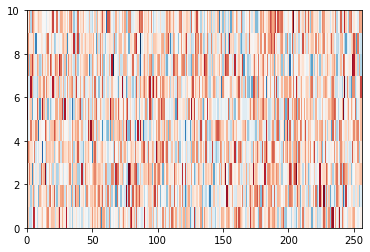

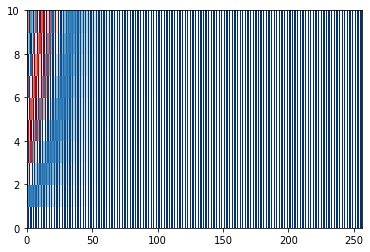

In [30]:
"""
(1) Positional Encoding

(1)-a : Make the Learnable Embedding (using nn.Embedding) and Visualize it using matplotlib.pyplot.pcolormesh.

(1)-b : Absolute sinusoid-baesd Positinal Encoding is given in the file of pe_fall22.pickle.
Visualize it using matplotlib.pyplot.pcolormesh.

Please refer to the images sinusoid.png & learnable.png in data directory as answer exmples.
"""
import matplotlib.pyplot as plt

########## Your Code #########
# a. Learnable Embedding (using nn.Embedding)
pos = torch.arange(MAX_LENGTH).unsqueeze(1)
pos_embedding = nn.Embedding(in_dim, emb_dim)(pos)
plt.pcolormesh(pos_embedding.squeeze(1).detach().numpy(), cmap='RdBu')
plt.show()

# b. Absolute sinusoid-baesd Positinal Encoding
with open('./data/pe_fall22.pickle', 'rb') as handle:
  pe = pickle.load(handle)
plt.pcolormesh(pe.squeeze(1), cmap='RdBu')

plt.show()




##############################




In [31]:
"""
(2) Make the Source Masking for the sample_x
Source Masking is a tensor of shape (MAX_LENGTH), in which Padded tokens are True, and the rest of the tokens are False.
"""
x, y = next(iter(train_dataloader))
sample_x = x[0]

########## Your Code #########
source_mask = (sample_x == dataset.input_lang_pad)

print("source mask = pad masking")
print(source_mask.squeeze().tolist())
##############################

source mask = pad masking
[False, False, False, False, False, False, False, False, False, True]


In [32]:
"""
(2) Make the Target Maskings for the sample_y.

(2)-1 : pad_mask_neg
pad_mask_neg is a tensor of shape (MAX_LENGTH), in which Padded tokens are False, and the rest of the tokens are True.

(2)-2 : sub_mask 
sub_mask is a tensor of shape (MAX_LENGTH, MAX_LENGTH), in which only the tokens of the current timestep are True.
You can use torch.tril function.

(2)-3 : target mask (MAX_LENGTH, MAX_LENGTH)
target mask is a tensor of shape  (MAX_LENGTH, MAX_LENGTH), 
in which both of the not-padded tokens and the tokens of the current timestep are True.

"""
x, y = next(iter(train_dataloader))
sample_y = y[0]

########## Your Code #########
pad_mask_neg = (sample_y != dataset.output_lang_pad).unsqueeze(1)
sub_mask = torch.tril(torch.ones((MAX_LENGTH, MAX_LENGTH))).bool()
target_mask = pad_mask_neg.permute(2,1,0) & sub_mask.unsqueeze(0)

print("\ntarget mask = pad masking + subsequent masking")
print(pad_mask_neg.squeeze().tolist())
print()
print(sub_mask.squeeze())
print()
print(target_mask.squeeze())
##############################


target mask = pad masking + subsequent masking
[True, True, True, True, True, True, True, False, False, False]

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])

tensor([[ True, False, False, False, False, False, False, False, False, False],
     

OUTPUT EXAMPLE
```
target mask = pad masking + subsequent masking
[True, True, True, True, True, True, False, False, False, False]

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False]])
```



In [35]:
"""
(3) Implement Seq2seq model with Transformer
"""

from torch.nn import Transformer ## 과제에서는 사용하면 안됨

class TransSeq2Seq(nn.Module):
    def __init__(self, hid_dim, ff_dim, n_heads, n_enc_layers, n_dec_layers, dropout_p):
        super().__init__()
        """
        - Define self.input_emb and self.output_emb layer same as in Q(2) and Q(3).
        - self.dropout will be used after adding the embedded_pos to the embedded_x and embedded_y.
        - use 'gelu' for activation function in Transformer layer
        """
        self.input_emb = nn.Embedding(in_dim, hid_dim)
        self.output_emb = nn.Embedding(out_dim, hid_dim)
        self.pos_emb = nn.Embedding(MAX_LENGTH, hid_dim)
        ########## Your Code #########
        self.transformer = Transformer(d_model=hid_dim,
                                       nhead = n_heads,
                                       num_encoder_layers = n_enc_layers,
                                       num_decoder_layers = n_dec_layers,
                                       dim_feedforward=ff_dim,
                                       dropout = dropout_p,
                                       activation='gelu')
        self.dropout = nn.Dropout(dropout_p)
        ##############################

    def forward(self, src, trg):
        """
        1) Get the embedded_x using self.input_emb and src (source)
        2) Get the embedded_y using self.input_emb and trg (target)
        3) Get the embedded_pos using self.pos_emb
        4) Apply the dropout to embedded_x and embedded_y
        5) Get the output using self.transformer
        """
        ########## Your Code #########
        embedded_pos = self.pos_emb(torch.arange(MAX_LENGTH).unsqueeze(1))
        embedded_x = self.input_emb(src)
        embedded_y = self.output_emb(trg)

        embedded_x = self.dropout(torch.sum(embedded_x + embedded_pos, dim=1))
        embedded_y = self.dropout(torch.sum(embedded_y + embedded_pos, dim=1))

        return self.transformer(embedded_x, embedded_y)
        ##############################



In [36]:
"""
(4) Define the Transformer model.
Compute and print the output of the model using sample_x and sample_y as inputs.
"""
########## Your Code #########
emb_dim = 256
hid_dim = emb_dim
ff_dim = 1024
n_heads = 8
n_enc_layers = 3
n_dec_layers = 5
dropout_p = 0.1

model = TransSeq2Seq(hid_dim, ff_dim, n_heads, n_enc_layers, n_dec_layers, dropout_p)
output = model(sample_x, sample_y)
print(output.shape) # (10, 256)
##############################

torch.Size([10, 256])


# Practice 3. BERT fine-tuning

In [ ]:
"""
In this Practice, you are not going to solve questions.
Run the codes and see how we can use pretrained BERT.
"""

**References**

1. [huggingface BERT documentation](https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#bert)

2. [masked language modelling with bert](https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c)

3. [fine-tuning bert for text classification in pytorch](https://luv-bansal.medium.com/fine-tuning-bert-for-text-classification-in-pytorch-503d97342db2)

4. [pytorch sentiment classification github](https://github.com/clairett/pytorch-sentiment-classification/tree/master/data/SST2)

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
from tqdm import tqdm
from torch.optim import AdamW

MX_LENGTH = 50
BATCH_SIZE = 32
MASK_RATIO = 0.2 # 0.15 논문
EPOCHS = 3
learning_rate = 5e-3 #5e-5 -> loss: 1~2 after one epoch

In [ ]:
# Prepare Dataset
class BertDataset(Dataset):
    def __init__(self, tokenizer, max_length=512, mask_ratio=0.15):
        super(BertDataset, self).__init__()
        self.train_csv=pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
        self.tokenizer=tokenizer
        self.target=self.train_csv.iloc[:,1]
        self.max_length = max_length
        self.mask_ratio = mask_ratio

    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        inputs = self.tokenizer.encode_plus(text=self.train_csv.iloc[index,0],
                                            padding='max_length',
                                            truncation=True,
                                            add_special_tokens=True,
                                            return_tensors='pt',
                                            max_length=self.max_length,)

        return {'input_ids': inputs["input_ids"].clone().detach(),
                'token_type_ids': inputs["token_type_ids"].clone().detach(),}

    def _apply_masking(self, x):
        rand = torch.rand(x['input_ids'].shape)
        mask = (rand < self.mask_ratio) * (x['input_ids'] != 101) * (x['input_ids'] != 102) * (x['input_ids'] != 0) # t/f tensor

        selection = torch.flatten(mask[0].nonzero()).tolist() # idxs masked
        x['input_ids'][0, selection] = 103 # apply MASK token

        return x

    def collate_fn(self, data):
        batch={'input_ids':None, 'labels':None}
        
        # copy ids
        tmp = [item['input_ids'] for item in data]
        batch['labels'] = torch.stack(tmp).squeeze(1)
        
        # create mask tensor
        data = list(map(self._apply_masking, data))
        tmp = [item['input_ids'] for item in data]
        batch['input_ids'] = torch.stack(tmp).squeeze(1)

        return batch

In [ ]:
# Dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset= BertDataset(tokenizer, max_length=MX_LENGTH, mask_ratio=MASK_RATIO)

# Dataloader
dataloader=DataLoader(dataset=dataset,batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn)


In [ ]:
# Explore Dataset 
for i, batch_data in enumerate(dataloader):
    if i==0:
        print("data shape")
        print(batch_data['labels'].shape) # batch_size * max_length
        print()
        print("before masking")
        print(batch_data['labels'][0]) # 101: CLS, 102: SEP / we use single sentence for fine-tuning task
        print()
        print("after masking (MASK = 103)")
        print(batch_data['input_ids'][0])

In [ ]:
# Pretrained model
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [ ]:
# Train
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()
optim = AdamW(model.parameters(), lr=learning_rate)

for epoch in range(EPOCHS):
    loop = tqdm(dataloader, leave=True)
    for batch in loop:
        optim.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()

        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())